# Edris's Analytics on Trace Data

This notebook is an independent attempt to draw insight from trace data, taking lessons from [Sushant's work](https://github.com/sand-ci/Analytics). Rather than iterating directly on that work, this is being built out independently so that I can learn how everything fits together and begin drawing my own insights.

In [1]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan, bulk
from datetime import datetime
from pathlib import Path
import csv
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import timeit
import pyarrow.parquet as pq

# Enable verbose errors, to make debugging easier
%xmode Verbose

PROJECT_ROOT = Path.cwd()

Exception reporting mode: Verbose


## Testing and Custom Modules

As I'm building out functionality, I will first test it directly in this notebook and, as it becomes well-defined, I'll be factoring it out into independent modules. As those modules are added, they'll be included below and I'll be using the autoreload IPython extension so that I don't need to restart my IPython Kernel every time I update a module.

| File | Content |
| ---- | ------- |
| es_queries.py | ElasticSearch queries. |
| query_analysis.py | Analysis of ES queries. |
| make_network.py | Construct or manipulate a network |
| draw_network.py | Draw a network |

If an avenue of testing proves unproductive or is otherwise abandoned, that material will be migrated to `Test.ipynb`.

In [2]:
%load_ext autoreload
%autoreload 2

import src.es_queries as esq
import src.query_analysis as qa
import src.make_network as mn
import src.draw_network as dn

## Connecting to ElasticSearch

The login method takes a username and password or a filename. If none are provided, the filename defaults to `credentials.key`, but all `.key` files are in `.gitignore` for security reasons. As such, to use that file, it will need to be recreated whenever this repo is cloned and populated with the username on the first line and password on the second line.

In [4]:
es = esq.es_login()

Connection Successful


## Getting Unique Pairs of PerfSonar nodes

I used `scan` in place of `search`, which returns a generator instead of a dictionary, included only necessary fields by using `_source = [list of fields]` and omitted metadata by using `filter_path` (including only `_source`, `_shards` and `_index`). I could then iterate through this generator to extract the source/destination pairs that meet my criteria and log those that do not.

In [5]:
td_scan = esq.trace_derived_scan(es)

In [6]:
qa.reset_vars()
qa.make_ps_pairs(td_scan)

Successfully identified 24503 perfSONAR pairs.


## Iterating over `ps_trace`

With the `qa` module now containing a set of valid `ps_pairs`, we can now pull data regarding those pairs from `ps_trace`. As `ps_trace` is huge, we only ever pull a compartively small time period.

### Save Scan Results

Save a day worth of data from `ps_trace` to a parquet file for each of seven days. This allows us to work with the data locally and potentially more efficiently.

In [8]:
for i in range(7):
    start = datetime(year=2020, month=7, day=(7 + i), hour=0).strftime("%Y-%m-%dT%H:%M:%S.000Z")
    end = datetime(year=2020, month=7, day=(8 + i), hour=0).strftime("%Y-%m-%dT%H:%M:%S.000Z")
    scan_gen = esq.ps_trace_scan(es, start, end)
    filename = 'ps_trace' + str(i) + '.pa'
    qa.save_data(scan_gen, filename)

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1701240
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1733844
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1762514
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1756969
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1723861
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1755067
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1765885


### Working with batches

As we have just created batches of data that encompass a day each, if we want to iterate through all of them and aggregate information, we'll likely run into memory constraints. As such, we may want to put the results into generators. The function below allows us to chain together generators, so we can create a generator for each day and append it to the generator from the days before.

In [9]:
def chain(*iters):
    for iterable in iters:
        yield from iterable

## Route Stability

To determine how stable routes are, we are iterating through 7 days of data and tracking when the route between any two ps nodes changes.

_Note: This may not run on less than 16 GB of RAM and is quite slow._

In [10]:
start = datetime(year=2020, month=7, day=7, hour=0).strftime("%Y-%m-%dT%H:%M:%S.000Z")
end = datetime(year=2020, month=7, day=14, hour=0).strftime("%Y-%m-%dT%H:%M:%S.000Z")
ps_trace = esq.ps_trace_scan(es, start, end)

In [11]:
qa.route_changes(ps_trace)

Successfully identified 25845 routes that had activity.


## Edge Frequency

For each day, I converted the column containing lists of hops to a column of tuples of hops, so it can be used in aggregation (it's hashable). I then proceed to count the number of times each set of hops occurs in a given day (this tells us how many times each edge along those hops occurs). Both columns are converted to lists that are appended to existing list of tuples of hops and list of counts. 

_Note:_ This means that a tuple of hops may occur more than once in the larger list (up to once per day), but this isn't really an issue, as we are ultimately only using this to create a list of edges and their frequency.

In [14]:
hops = []
counts = []
for i in range(7):
    df = pd.read_parquet(str(PROJECT_ROOT / 'data' / ('ps_trace' + str(i) + '.pa')))
    df = df.rename(columns={'timestamp':'count'})
    df = df.drop(['dest', 'route-sha1', 'src'], axis=1)
    df['hops'] = df['hops'].apply(tuple)
    df = df.groupby(['hops']).count()
    df = df.reset_index()
    hops.extend(df['hops'].tolist())
    counts.extend(df['count'].tolist())

In [15]:
edges = {}
for i in range(len(hops)):
    for j in range(len(hops[i]) - 1):
        src = hops[i][j]
        dest = hops[i][j + 1]
        
        if (src, dest) in edges:
            edges[(src, dest)] = edges[(src, dest)] + counts[i]
        else: 
            edges[(src, dest)] = counts[i]

In [16]:
edges_ordered = sorted(edges.items(), key=lambda x: x[1], reverse=True)

### Representing the Core of the Network

Now that we have a list of edges in order of the frequency with which they occur in the network, we can create graphs using `networkx` based on the $n$ most central edges and then visualizations of those graphs using the default spring layout (which pushes unconnected components to the periphery so they are easier to see). From this we can make observations about the relationships of the most central edges in the network.

_Note:_ The tools for creating and representing graphs of the network are adapted from the `toy_network` project.

In [17]:
edge_lists = []
node_lists = []

for i in [200 * n for n in range(1, int(len(edges_ordered) / 200))] + [len(edges_ordered)]:
    edge_lists.append([edge[0] for edge in edges_ordered[:i]])
    nodes = []
    for edge in edges_ordered[:i]:
        nodes.append(edge[0][0])
        nodes.append(edge[0][1])
    node_lists.append(list(dict.fromkeys(nodes)))

In [20]:
G = mn.make_network(edges=edges_ordered)
dn.draw_networks(G, edge_lists, node_lists)

#### Drawing Edges in Context

For a different perspective, we can create a graph based on all edges (not just the most frequent), allow `networkx` to determine a Spring layout for that graph, but then only fill in the $n$ most frequent edges. This allows us to see where the most frequent edges are clustered in the context of the larger graph.

In [ ]:
for n in [200 * x for x in range(1, int(len(edges_ordered) / 200))] + [len(edges_ordered)]:
    G = mn.make_network(edges=edges_ordered[:n])
    dn.draw_network(G)

#### Drawing the Entire Network

We can always simply draw the entire network, with all the edges (not just the most frequent ones).

_Note:_ Currently, the first edge, between a source and the first device on the trace path, is not included in the graph. This presumably is why there is a single component that is completely disconnected from the graph.

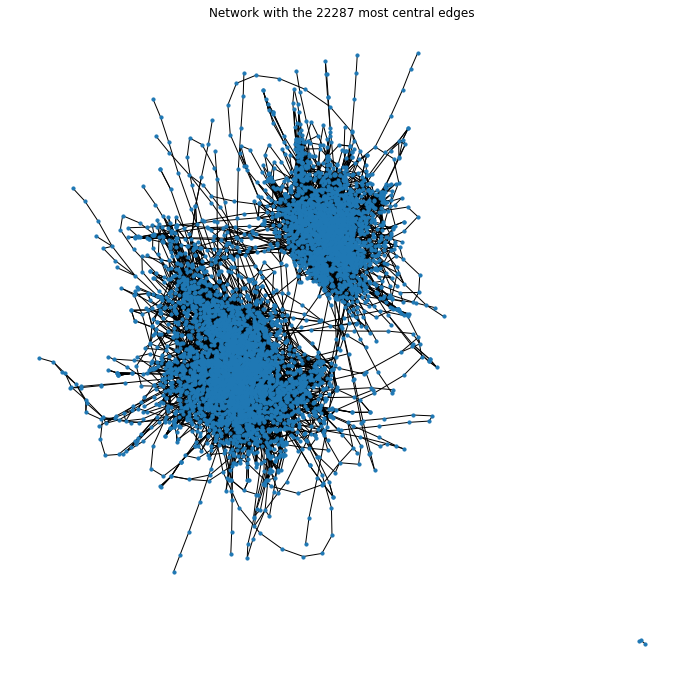

In [54]:
G = mn.make_network(edges=edges_ordered)
dn.draw_network(G)

### Count Edges and Unique Nodes

In [49]:
len(edges_ordered)

22817

In [77]:
ps_nodes = {}
for i in range(7):
    df = pd.read_parquet(str(PROJECT_ROOT / 'data' / ('ps_trace' + str(i) + '.pa')))
    ps = df['src'].tolist()
    ps.extend(df['dest'].tolist())
    for node in ps:
        if node not in ps_nodes:
            ps_nodes[node] = True

In [78]:
len(ps_nodes)

423

In [79]:
nodes = {}
for node in ps_nodes:
    nodes[node] = True
for hoplist in hops:
    for hop in hoplist:
        if hop not in nodes:
            nodes[hop] = True            

In [80]:
len(nodes)

5968

# Testing

Below this point are disorganized snippets of code used while testing various features.

In [ ]:
route_life = qa.route_life(60)

In [ ]:
route_change = {}
for route in route_life:
    if route_life[route] in route_change:
        route_change[route_life[route]] = route_change[route_life[route]] + 1
    else:
        route_change[route_life[route]] = 1

route_change

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter([x for x in route_change.keys()], [y for y in route_change.values()])
plt.show()

In [ ]:
qa.get_route_changes()

In [ ]:
start = datetime(year=2020, month=7, day=7, hour=8).strftime("%Y-%m-%dT%H:%M:%S.000Z")
end = datetime(year=2020, month=7, day=7, hour=9).strftime("%Y-%m-%dT%H:%M:%S.000Z")
ps_trace = esq.ps_trace_scan(es, start, end)

In [ ]:
df = pd.read_parquet(str(PROJECT_ROOT / 'data' /'route_changes.pa'))

In [ ]:
df['Life'] = (7 * 24 / df['changetimes'].str.len())
df = df.rename(columns={'changetimes':'Paths'})
dfl = df.drop(['dest', 'sha', 'src'], axis=1)

In [ ]:
dfl = df.groupby(['Life']).count()

In [ ]:
dfl = dfl.reset_index()

In [ ]:
dfl.head()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.rcParams.update({'font.size': 18})
dfl.plot(x = 'Life', y = 'Paths', logy = True, kind = 'scatter', ax = ax)
# dfl.plot(x = 'Life', y = 'Paths', kind = 'scatter', logx = True, logy = True, ax = ax[1])
# ax[0].set_xlim(170, 0)
ax.set_xlabel('Life of a path in hours')
ax.set_ylabel('Paths count (' + str(dfl['Paths'].sum()) + ' total) - log scale')
ax.set_title('Over 7 days (168 hrs), how long does any path between PS nodes stays stable?')
# ax[1].set_xlim(170, 0)
# ax[1].set_xlabel('Life of a path in hours (log scale)')
# ax[1].set_ylabel('Paths count (log scale)')
plt.gca().invert_xaxis()
plt.show()

In [ ]:
dfn = dfl.copy()
dfn['Paths'] = dfn['Paths'] / dfn['Paths'].sum()
# dfn['Life'] = dfn['Life'] / dfn['Life'].max()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.rcParams.update({'font.size': 18})
dfn.plot(x = 'Life', y = 'Paths', kind = 'scatter', ax = ax[0])
dfn.plot(x = 'Life', y = 'Paths', kind = 'scatter', logx = True, logy = True, ax = ax[1])
ax[0].set_xlabel('Life of a path (hours)')
ax[0].set_ylabel('Paths (count)')
ax[0].set_title('Over 7 days (168 hrs), how long does any path between PS nodes stays stable?')
ax[1].set_xlabel('Life of a path (hours) - log scale')
ax[1].set_ylabel('Paths (count) - log scale')
plt.show()

In [ ]:
all_hops = []
for i in range(7):
    pst = pd.read_parquet(str(PROJECT_ROOT / 'data' / 'ps_trace' + str(i) + '.pa'))
    hops = pst['hops'].tolist()
    hops = pd.core.common.flatten(hops)
    all_hops = chain(all_hops, hops)

In [ ]:
hops_df = pd.DataFrame(list(all_hops), columns=['Hops'])

In [ ]:
hop_counts = hops_df['Hops'].value_counts()

In [ ]:
# hop_c2 = pd.DataFrame(hop_counts).reset_index().rename(columns={'index':'Node', 'Hops': 'Count'})
hop_c2.head(n=100)

In [ ]:
def record_count():
    with open('test.csv', 'w', newline='') as csvfile:
        fieldnames = ['src', 'dest', 'route-sha1', 'hops', 'timestamp']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writerow({'src':'src', 'dest':'dest', 'route-sha1':'route-sha1', 'hops':'hops', 'timestamp':'timestamp'})
        
        start = datetime(year=2020, month=7, day=7, hour=8).strftime("%Y-%m-%dT%H:%M:%S.000Z")
        end = datetime(year=2020, month=7, day=7, hour=9).strftime("%Y-%m-%dT%H:%M:%S.000Z")
        ps_trace = esq.ps_trace_scan(es, start, end)
        records = 0
    #     df = pd.DataFrame(data=next(ps_trace)["_source"])
        for trace in esq.scan_gen(ps_trace):
    #         df.append(trace['_source'], ignore_index=True)
            writer.writerow(trace)
            records += 1
            if not records % 1000:
                print(records)
        print(records)
    #     return df
    
print(timeit.timeit('df = record_count()', setup="from __main__ import record_count", number=1))

In [ ]:
def record_count():
    data = []
    start = datetime(year=2020, month=7, day=7, hour=8).strftime("%Y-%m-%dT%H:%M:%S.000Z")
    end = datetime(year=2020, month=7, day=7, hour=9).strftime("%Y-%m-%dT%H:%M:%S.000Z")
    ps_trace = esq.ps_trace_scan(es, start, end)
    records = 0
#     df = pd.DataFrame(data=next(ps_trace)["_source"])
    for trace in esq.scan_gen(ps_trace):
#         df.append(trace['_source'], ignore_index=True)
        data.append(trace)
        records += 1
        if not records % 1000:
            print(records)
    print(records)
    df = pd.DataFrame(data)
    df.to_parquet(str(PROJECT_ROOT / 'data' / 'test.pa'), engine='pyarrow')
#     return df
    
print(timeit.timeit('df = record_count()', setup="from __main__ import record_count", number=1))

In [ ]:
# df = pd.read_csv('test.csv')
df = pd.read_parquet(str(PROJECT_ROOT / 'data' / 'test.pa'), engine='pyarrow')

In [ ]:
df

In [ ]:
start = datetime(year=2020, month=7, day=7, hour=8).strftime("%Y-%m-%dT%H:%M:%S.000Z")
end = datetime(year=2020, month=7, day=14, hour=8).strftime("%Y-%m-%dT%H:%M:%S.000Z")
ps_trace = esq.ps_trace_scan(es, start, end, include=["hops"])

In [ ]:
df

In [ ]:
%debug

### Evaluating a larger dataset

Creating a generator spanning a day of data, I can identify routes 

In [ ]:
start = datetime(year=2020, month=7, day=8, hour=8).strftime("%Y-%m-%dT%H:%M:%S.000Z")
end = datetime(year=2020, month=7, day=9, hour=8).strftime("%Y-%m-%dT%H:%M:%S.000Z")
ps_trace = esq.ps_trace_scan(es, start, end)

In [ ]:
changed = {}
removed_edges = {}
added_edges = {}

for trace in ps_trace:
    trace = trace['_source']
    if not trace['src_production'] or not trace['dest_production']:
        continue
    try:
        src = trace['src']
        dest = trace['dest']
        sha = trace['route-sha1']
        hops = trace['hops']
        max_rtt = trace['max_rtt']
        looping = trace['looping']
        time = trace['timestamp']
    except KeyError:
        continue

    if (src, dest) in routes and sha != routes[(src, dest)]['sha'] and max_rtt > routes[(src, dest)]['max_rtt']:
        og_path_edges = []
        new_path_edges = []
        removed = []
        added = []

        for i in range(len(routes[(src, dest)]['hops']) - 1):
            s = routes[(src, dest)]['hops'][i]
            d = routes[(src, dest)]['hops'][i+1]
            og_path_edges.append((s, d))
            og_path_edges.append((d, s))
        
        for i in range(len(hops) - 1):
            s = hops[i]
            d = hops[i+1]
            new_path_edges.append((s, d))
            new_path_edges.append((d, s))

        for edge in og_path_edges:
            if edge not in new_path_edges:
                removed.append(edge)
                if edge in removed_edges:
                    removed_edges[edge]['count'] = removed_edges[edge]['count'] + 1
                    removed_edges[edge]['time'].append(time)
                else:
                    removed_edges[edge] = {'count': 1, 'time': [time]}
        
        for edge in new_path_edges:
            if edge not in og_path_edges:
                added.append(edge)
                if edge in added_edges:
                    added_edges[edge]['count'] = added_edges[edge]['count'] + 1
                    added_edges[edge]['time'].append(time)
                else:
                    added_edges[edge] = {'count': 1, 'time': [time]}
        
        changed[(src, dest)] = {'added': added, 'removed': removed}

In [ ]:
def plot_traceroute_changes(edges_impacted):
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.set_title('Edges removed from formerly stable paths')
    ax.set_ylabel('Number of paths an edge was formerly on')
    ax.set_xlabel('Edges formerly on paths')
    ax.bar([str(edge) for edge in edges_impacted.keys()], [edges_impacted[edge]['count'] for edge in edges_impacted.keys()])
    ax.tick_params(labelrotation=20)
#     ax.set_yticks([i for i in range(int(max(edges_impacted.values()))+1)])

#     file_name = 'Traceroute-' + str(edge_removed[0]) + '_' + str(edge_removed[1]) + '.png'
#     plt.savefig(str(PROJECT_ROOT / 'reports' / 'figures' / file_name))
    plt.show()

In [ ]:
plot_traceroute_changes(removed_edges)